# Gaussian Naive Bayes Classifier

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import timeit

## GaussianNB Classifier
An implementation of a Gaussian Naive Bayes that fits the framework.

In [22]:
class MyGaussianNB(BaseEstimator, ClassifierMixin):
    def fit(self, xt, yt):
        xt = np.array(xt)
        yt = np.array(yt)

        # first phase: compute class priors
        self._classes, self._class_priors = np.unique(yt, return_counts=True)
        self._class_priors = self._class_priors / float(np.sum(self._class_priors))  

        # second phase: compute all features' means and variances
        xt_split = [xt[yt==cl] for cl in self._classes]
        self._means = np.array([np.mean(xtcl, axis=0) for xtcl in xt_split])
        self._vars = np.array([np.var(xtcl, axis=0) for xtcl in xt_split])
        return self

    def predict(self, xtests):
        xtests = np.array(xtests)

        probas = self._compute_probas(xtests)
        return np.array([self._classes[i] for i in np.argmax(probas, axis=0)])
        
    def predict_proba(self, xtests):
        xtests = np.array(xtests)

        probas = self._compute_probas(xtests)
        return np.transpose(probas / np.sum(probas, axis=0))

    def _compute_probas(self, xtests):
        return np.array([
            [
                self._class_priors[i] * np.product(self._conditional_proba(xtest, self._means[i], self._vars[i])) 
                for xtest in xtests
            ]
            for i in range(len(self._classes))
        ])
    
    @staticmethod
    def _conditional_proba(xt, m, var):
        return np.exp(-np.power(xt-m, 2)/(2*var))/np.sqrt(2*np.pi*var)

In [23]:
def test_gaussian_on_dataset(x_train, y_train, x_test, y_test):
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    print("Numpy GNB:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy score:")
    print(accuracy_score(y_test, y_pred))

    print()
    
    mgnb = MyGaussianNB()
    mgnb.fit(x_train,y_train)
    y_pred = mgnb.predict(x_test)
    print("My GNB:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy score:")
    print(accuracy_score(y_test, y_pred))

    y_score = gnb.predict_proba(x_test)
    fprG, tprG, t = roc_curve(y_test, y_score[:,1])
    roc_aucG  = auc(fprG, tprG)

    y_score = mgnb.predict_proba(x_test)
    fprN, tprN, t = roc_curve(y_test, y_score[:,1])
    roc_aucN = auc(fprN, tprN)
    
    %matplotlib inline
    plt.figure()
    lw = 2
    plt.plot(fprG, tprG, color='red',
            lw=lw, label='ROC NB (area = %0.2f)' % roc_aucG)
    plt.plot(fprN, tprN, color='blue',
            lw=lw, label='ROC custom NB (area = %0.2f)' % roc_aucN)

    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Analysis for Diabetes data')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
def test_speed_on_dataset(x_train, y_train, x_test, y_test, repeat=1000):
    gnb = GaussianNB()
    gnb_fit_time = timeit.timeit(lambda: gnb.fit(x_train, y_train), number=repeat)
    gnb_predict_time = timeit.timeit(lambda: gnb.predict(x_test), number=repeat)
    
    print(f'Numpy GNB fit performance: {gnb_fit_time}s ({repeat} times)')
    print(f'Numpy GNB predict performance: {gnb_predict_time}s ({repeat} times)')

    mgnb = MyGaussianNB()
    mgnb_fit_time = timeit.timeit(lambda: mgnb.fit(x_train, y_train), number=repeat)
    mgnb_predict_time = timeit.timeit(lambda: mgnb.predict(x_test), number=repeat)

    print(f'My GNB fit performance: {mgnb_fit_time}s ({repeat} times)')
    print(f'My GNB predict performance: {mgnb_predict_time}s ({repeat} times)')

## Penguins dataset
Running Gaussian Naive Bayes on the penguin dataset.

In [25]:
penguins_af = pd.read_csv('penguins_af.csv', index_col = 0)
print(penguins_af.shape)
penguins_af.head()

(333, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [26]:
f_names = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g']
penguins = penguins_af[f_names + ['species']]
penguins2C = penguins.loc[penguins['species'].isin(['Adelie','Chinstrap'])]
penguins2C['target'] = np.where(penguins2C['species'] == 'Adelie', 1, 0)
penguins2C.pop('species')
penguins2C.head()

<ipython-input-26-83705144b2ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins2C['target'] = np.where(penguins2C['species'] == 'Adelie', 1, 0)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,target
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
4,36.7,19.3,193.0,3450.0,1
5,39.3,20.6,190.0,3650.0,1


In [27]:
y = penguins2C.pop('target').values
X_raw = penguins2C.values
feature_names = penguins2C.columns
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
X_train.shape, X_test.shape

((107, 4), (107, 4))

Numpy GNB:
Confusion Matrix:
[[30  2]
 [ 2 73]]
Accuracy score:
0.9626168224299065

My GNB:
Confusion Matrix:
[[30  2]
 [ 2 73]]
Accuracy score:
0.9626168224299065


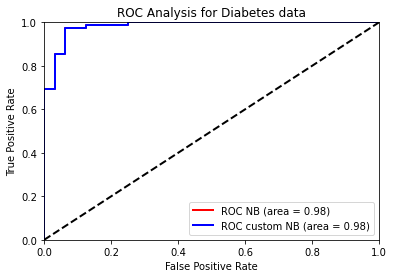

In [28]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [29]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Numpy GNB fit performance: 0.43182190000001697s (1000 times)
Numpy GNB predict performance: 0.09929840000000922s (1000 times)
My GNB fit performance: 0.13387550000001625s (1000 times)
My GNB fit performance: 2.6813941000000057s (1000 times)


In [30]:
diabetes = pd.read_csv('diabetes.csv', index_col = 0)
print(diabetes.shape)
diabetes.head()

(768, 8)


,plas,pres,skin,insu,mass,pedi,age,neg_pos
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,tested_positive
1,85,66,29,0,26.6,0.351,31,tested_negative
8,183,64,0,0,23.3,0.672,32,tested_positive
1,89,66,23,94,28.1,0.167,21,tested_negative
0,137,40,35,168,43.1,2.288,33,tested_positive


In [31]:
diabetes['target'] = np.where(diabetes['neg_pos'] == 'tested_positive', 1, 0)
diabetes.pop('neg_pos').values
diabetes.head()

,plas,pres,skin,insu,mass,pedi,age,target
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [32]:
y = diabetes.pop('target').values
Xorig = diabetes.values
scaler = StandardScaler()
X = scaler.fit_transform(Xorig)
X.shape, y.shape

((768, 7), (768,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

Numpy GNB:
Confusion Matrix:
[[141  15]
 [ 43  57]]
Accuracy score:
0.7734375

My GNB:
Confusion Matrix:
[[141  15]
 [ 43  57]]
Accuracy score:
0.7734375


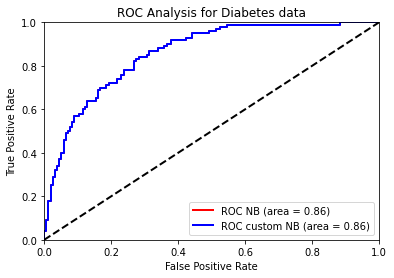

In [34]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [35]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Numpy GNB fit performance: 0.5150896000000103s (1000 times)
Numpy GNB predict performance: 0.12025880000001621s (1000 times)
My GNB fit performance: 0.1887245000000064s (1000 times)
My GNB fit performance: 6.0026095999999995s (1000 times)


In [36]:
reviews = pd.read_csv('HotelRevHelpfulness.csv', index_col=0)
print(reviews.shape)
reviews.head()

(486, 24)


,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,aveRatingUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
hotelId,,,,,,,,,,,,,,,,,,,,,
17420,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,4.333333,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1397,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,4.333333,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
1348,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,4.166667,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
5940,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,3.527778,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
38,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,3.500000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


In [37]:
y = reviews.pop('reviewHelpfulness').values
x_raw = reviews.values
scaler = StandardScaler()
x = scaler.fit_transform(x_raw)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((324, 23), (324,), (162, 23), (162,))

Numpy GNB:
Confusion Matrix:
[[32 32]
 [31 67]]
Accuracy score:
0.6111111111111112

My GNB:
Confusion Matrix:
[[32 32]
 [31 67]]
Accuracy score:
0.6111111111111112


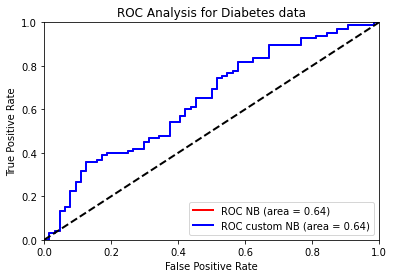

In [39]:
test_gaussian_on_dataset(x_train, y_train, x_test, y_test)

In [40]:
test_speed_on_dataset(x_train, y_train, x_test, y_test)

Numpy GNB fit performance: 0.5295272000000182s (1000 times)
Numpy GNB predict performance: 0.13513359999998897s (1000 times)
My GNB fit performance: 0.18463440000002151s (1000 times)
My GNB fit performance: 4.468188900000001s (1000 times)
